<a href="https://colab.research.google.com/github/JuanCruzC97/timmd_keras/blob/main/Scenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scenes


## Dataset

El dataset Scenes contiene cerca de 25.000 imágenes de paisajes o escenas varias. Unas 17.000 imágenes tienen la etiqueta o *label* correspondiente.

Las siguientes son las labels originales del dataset. Cada imagen pertenece a alguna de estas 6 clases.

0. Buildings
1. Forests
2. Glacier
3. Mountains
4. Sea
5. Street


[Link al Dataset](https://www.kaggle.com/datasets/nitishabharathi/scene-classification)

### Kaggle

Podemos descargar directamente desde Kaggle el dataset y cargarlo a Google Colab. Es necesario tener una cuenta registrada en Kaggle. De la cuenta de Kaggle debemos generar un token que se guarda como un archivo .json. 

Tenemos un tutorial en Colab del uso de la API de Kaggle.

[Tutorial Kaggle API](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb#scrollTo=OppyMnCuWjzJ)


[Obtención de Datos del Usuario](https://www.kaggle.com/me/account)

In [ ]:
# Instalamos la libreria de Kaggle en Colab
!pip install kaggle

In [ ]:
# Importamos el archivo a Colab.
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Movemos el archivo kaggle.json a la carpeta correspondiente.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
# Descargamos el dataset en Colab.
!kaggle datasets download -d nitishabharathi/scene-classification

100% 361M/361M [00:02<00:00, 172MB/s]
100% 361M/361M [00:02<00:00, 132MB/s]


In [ ]:
# Descomprimimos los datos.
!unzip scene-classification.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: train-scene classification/train/5499.jpg  
  inflating: train-scene classification/train/55.jpg  
  inflating: train-scene classification/train/550.jpg  
  inflating: train-scene classification/train/5500.jpg  
  inflating: train-scene classification/train/5501.jpg  
  inflating: train-scene classification/train/5502.jpg  
  inflating: train-scene classification/train/5503.jpg  
  inflating: train-scene classification/train/5504.jpg  
  inflating: train-scene classification/train/5505.jpg  
  inflating: train-scene classification/train/5506.jpg  
  inflating: train-scene classification/train/5507.jpg  
  inflating: train-scene classification/train/5508.jpg  
  inflating: train-scene classification/train/5509.jpg  
  inflating: train-scene classification/train/551.jpg  
  inflating: train-scene classification/train/5510.jpg  
  inflating: train-scene classification/train/5511.jpg  
  inflating: train-scene 

## Importar Datos

Importamos los datos al Notebook.

In [ ]:
# Paquetes utilizados.
import numpy as np
import pandas as pd
import os
import plotly.express as px
from plotly.subplots import make_subplots
import time
import random

import tensorflow as tf
import keras
import cv2

In [ ]:
# Usando una lista de nombres de imágenes en un directorio genera un dataset con imágenes y labels.
def create_img_dataset(directory, img_list, labels_list, img_shape, scale=False, color_mode="rgb"):
  
  samples = len(img_list)
  shape = list(img_shape)
  shape.insert(0, samples)

  data = np.zeros(shape)
  targets = np.zeros((samples,1))

  for i, img in enumerate(img_list):

    try:
      data[i] = import_img_as_array(directory, img, color_mode)

    except:
      img_t = import_img_as_array(directory, img, color_mode)
      img_t = cv2.resize(img_t, dsize=tuple(shape[1:3]), interpolation=cv2.INTER_LINEAR)
      data[i] = img_t


    if scale:
      data[i] = data[i]/255

    targets[i] = labels_list[i]
  
  #targets = targets.ravel()

  return data, targets


# Importa una imágen de un directorio como un array.
def import_img_as_array(directory, img_path, color_mode="rgb"):

  path = os.path.join(directory, img_path)
  img = tf.keras.preprocessing.image.load_img(path, color_mode=color_mode)
  array = tf.keras.preprocessing.image.img_to_array(img)

  return array


def prediction_to_class(x):
  
  labels = {0:"Forests",
            1:"Mountains",
            2:"Sea",
            3:"Street"}

  return labels[x]

Generamos una lista de los nombres de los archivos (imágenes) de la carpeta Train. Para el desarrollo del trabajo vamos a tomar una muestra de n = 5.500 observaciones al azar y usaremos:

* 4000 para Train
* 500 para Validation
* 1000 para Test

Además, usaremos imágenes únicamente de las siguientes clases:

0. Forests
1. Mountains
2. Sea
3. Streets

In [ ]:
n = 5500
train_size = n - 1500

# Obtenemos el dataset con los nombres de imágenes y labels.
labels_df = pd.read_csv("train-scene classification/train.csv")
# Nos quedamos únicamente con labels 1, 3, 4, 5.
labels_df = labels_df.query("label in [1, 3, 4, 5]")
# Tomamos una muestra aleatoria de tamaño n.
labels_df = labels_df.sample(n=n, random_state=12, ignore_index=True)

# Corregimos las labels.
labels_df["label_name"] = labels_df["label"].map({1:"Forests" , 3:"Mountains" , 4:"Sea", 5:"Streets"})
labels_df["label"] = labels_df["label"].map({1:0 , 3:1 , 4:2,  5:3})

# Armamos los subsets de train, validation y test.
train = labels_df.iloc[:train_size].reset_index(drop=True)
val = labels_df.iloc[-1500:-1000].reset_index(drop=True)
test = labels_df.iloc[-1000:].reset_index(drop=True)

In [ ]:
# Vemos qué contiene el subset de Train.
print(train.shape)
train.head()

(4000, 3)


image_name  label label_name
0  14936.jpg      1  Mountains
1  11583.jpg      3    Streets
2  16252.jpg      1  Mountains
3  14288.jpg      1  Mountains
4    226.jpg      0    Forests

Cada imágen tiene dimensión 150 (alto) x 150 (ancho) x 3 (canal). Al tener 3 tenemos imágenes a color (Red Green Blue - RGB). Si tuviéramos las mismas imágenes pero en escala de grises tendríamos cada imagen de dimensión 150 x 150 x 1. ¿Tiene importancia el color en este caso?

In [ ]:
# Guardamos el tamaño de una imágen.
directory = "train-scene classification/train"
color = "rgb"
#color = "grayscale"

img_shape = import_img_as_array(directory, train["image_name"][0], color_mode=color).shape
print(img_shape)

(150, 150, 3)


Generamos los datasets usando la lista de archivos que creamos previamente.

In [ ]:
# Generamos los datos de entrenamiento.
train_data, train_targets = create_img_dataset(directory, train["image_name"], train["label"], img_shape, scale=True, color_mode=color)
# Generamos los datos de validación
val_data, val_targets = create_img_dataset(directory, val["image_name"], val["label"], img_shape, scale=True, color_mode=color)
# Generamos los datos de evaluación.
test_data, test_targets = create_img_dataset(directory, test["image_name"], test["label"], img_shape, scale=True, color_mode=color)

### ¿Qué tienen los arrays creados?

Vemos los tamaños de los datasets generados en todas sus dimensiones.




In [ ]:
train_data.shape

(4000, 150, 150, 3)

In [ ]:
train_targets.shape

(4000, 1)

In [ ]:
train_targets[:10]

array([[1.],
       [3.],
       [1.],
       [1.],
       [0.],
       [2.],
       [1.],
       [2.],
       [1.],
       [0.]])

¿Cómo se ve una imagen? Podemos usar la función `load_img` de `keras` para cargar la imagen rápidamente. Por otro lado, para usar un modelo vamos a trabajar con el *array* que tiene la información de cada pixel de la imagen.

Mountains


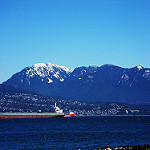

In [ ]:
n = 0

print(train["label_name"][n])
tf.keras.preprocessing.image.load_img(directory+"/"+train["image_name"][n], color_mode=color)

In [ ]:
print(import_img_as_array(directory, train["image_name"][n]).shape)
import_img_as_array(directory, train["image_name"][n])

(150, 150, 3)


array([[[ 47., 126., 219.],
        [ 47., 126., 218.],
        [ 47., 126., 218.],
        ...,
        [ 49., 133., 219.],
        [ 48., 132., 218.],
        [ 48., 132., 220.]],

       [[ 50., 129., 221.],
        [ 50., 129., 221.],
        [ 50., 129., 221.],
        ...,
        [ 55., 137., 223.],
        [ 54., 136., 222.],
        [ 54., 135., 224.]],

       [[ 50., 129., 221.],
        [ 50., 129., 221.],
        [ 51., 130., 222.],
        ...,
        [ 55., 137., 223.],
        [ 55., 137., 223.],
        [ 55., 137., 223.]],

       ...,

       [[ 19.,  50., 104.],
        [  1.,  36.,  64.],
        [ 10.,  41.,  85.],
        ...,
        [  1.,   7.,   5.],
        [  0.,   0.,   5.],
        [  4.,   3.,   9.]],

       [[ 26.,  54., 128.],
        [ 15.,  48., 102.],
        [  7.,  38., 102.],
        ...,
        [ 23.,  33.,  25.],
        [ 35.,  44.,  41.],
        [ 20.,  26.,  24.]],

       [[ 10.,  41.,  98.],
        [ 21.,  52., 119.],
        [ 12.,  

## Plots con Imágenes

In [ ]:
# Permite hacer el plot interactivo de imágenes pasando un array.
def plot_img(img_array, targets=None, grayscale=False):

  color_scale = "gray" if grayscale else "viridis"
  shape = img_array.shape

  if shape[:-1] == 1:
    img_array = img_array.reshape(shape[:-1])

  plot = px.imshow(img_array,
                   color_continuous_scale=color_scale,
                   height=700,
                   width=600,
                   template="simple_white")
  
  plot.update_layout(xaxis={"showticklabels":False},
                     yaxis={"showticklabels":False},
                     coloraxis={"colorbar":{"orientation":"h",
                                            "thickness":15,
                                            "y":-0.05,
                                            "yanchor":"bottom"}})
  if targets is not None:
    target_name = prediction_to_class(targets[0])

    plot.update_layout(title={"text":f'Label = {target_name}',
                              "font":{"size":20},
                              "x":0.5,
                              "y":0.9,
                              "xanchor":"center"})
  
  return plot


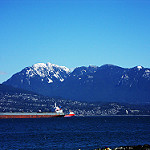


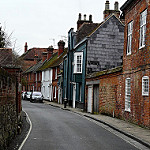


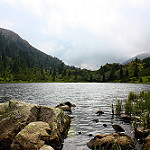


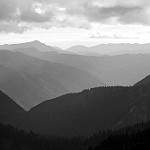


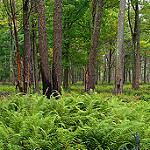


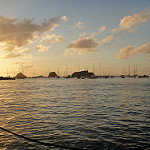


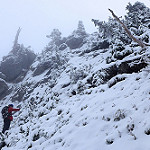


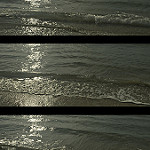


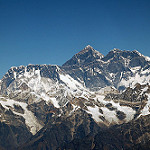


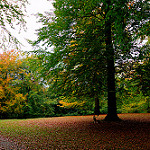

In [ ]:
# Hacemos el plot de las primeras 10 imágenes.
for i in np.arange(0,10):
  plot_img(train_data[i], train_targets[i], grayscale=False).show()

## Data Exploration

El dataset está bastante balanceado entre las distintas clases. Para estos casos podemos usar la métrica **Accuracy** para evaluar la performance del modelo. En caso de que las clases estuvieran altamente desbalanceadas deberíamos usar otra métrica, como F1-Score.

In [ ]:
print(train["label"].value_counts())
print(val["label"].value_counts())
print(test["label"].value_counts())

1    1098
3    1002
2     975
0     925
Name: label, dtype: int64
3    134
1    130
2    121
0    115
Name: label, dtype: int64
1    266
0    251
3    246
2    237
Name: label, dtype: int64


## Models

[Keras Documentation](https://keras.io/getting_started/)

### Functions

In [ ]:
# Gráfico de métricas durante el entrenamiento.
def plot_train_metrics(data, metric_train_list, metric_val_list=None, title=None):

  data["epochs"] = list(data.index)
  data = data.melt(id_vars = "epochs", var_name="metrics", value_name="value")

  if metric_val_list == None:
    for metric in metric_train_list:

      data_plot = data.query("metrics == @metric")

      plot = px.line(data_frame=data_plot,
                     x="epochs",
                     y="value",
                     height=500,
                     width=1000,
                     color_discrete_sequence=["#035397"],
                     title=title,
                     template="plotly_white")
      
      plot.update_layout(xaxis={"title":{"text":"Epochs"}},
                         yaxis={"title":{"text":metric.capitalize()}},
                         hovermode="x unified",
                         legend={"title":{"text":""},
                                 "orientation":"h",
                                 "yanchor":"bottom",
                                 "y":1.02,
                                 "xanchor":"right",
                                 "x":1})

      plot.show()
  
  else:
    for metric_train, metric_val in zip(metric_train_list, metric_val_list):

      data_plot = data.query("metrics in [@metric_train, @metric_val]")

      plot = px.line(data_frame=data_plot,
                     x="epochs",
                     y="value",
                     color="metrics",
                     height=500,
                     width=1000,
                     color_discrete_sequence=["#035397", "#E8630A"],
                     #custom_data=["epochs", metric_train, metric_val],
                     title=title,
                     template="plotly_white")
      
      plot.update_layout(xaxis={"title":{"text":"Epochs"}},
                         yaxis={"title":{"text":metric_train.capitalize()}},
                         hovermode="x unified",
                         legend={"title":{"text":""},
                                 "orientation":"h",
                                 "yanchor":"bottom",
                                 "y":1.02,
                                 "xanchor":"right",
                                 "x":1})
      
      plot.update_traces(hovertemplate=None)

      plot.show()


In [ ]:
def model_evaluation(model, X_train, y_train, X_val, y_val, X_test, y_test, result=False):
  eval = dict(train = model.evaluate(X_train, y_train, verbose=0, return_dict=True, batch_size=32),
              val = model.evaluate(X_val, y_val, verbose=0, return_dict=True, batch_size=32),
              test = model.evaluate(X_test, y_test, verbose=0, return_dict=True, batch_size=32))

  df_eval = pd.DataFrame(eval)
  display(df_eval)

  if result:
    return df_eval

### Baseline

Probamos cuál sería el porcentaje de aciertos si hacemos una predicción aleatoria. Si entrenamos un modelo, como primer paso, buscamos superar este baseline.

In [ ]:
# Baseline aleatorio.
np.random.seed(42)
print((train_targets == np.random.permutation(train_targets)).mean())
print((val_targets == np.random.permutation(val_targets)).mean())
print((test_targets == np.random.permutation(test_targets)).mean())

0.254
0.26
0.276


### Dense o Fully-Connected

Explicacion:

* Learning-Rate
* Batch Size
* Epochs
* Activations
* Loss
* Optimizer

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 67500)             0         
                                                                 
 dense (Dense)               (None, 512)               34560512  
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 34,692,868
Trainable params: 34,692,868
Non-trainable params: 0
_________________________________________________________________


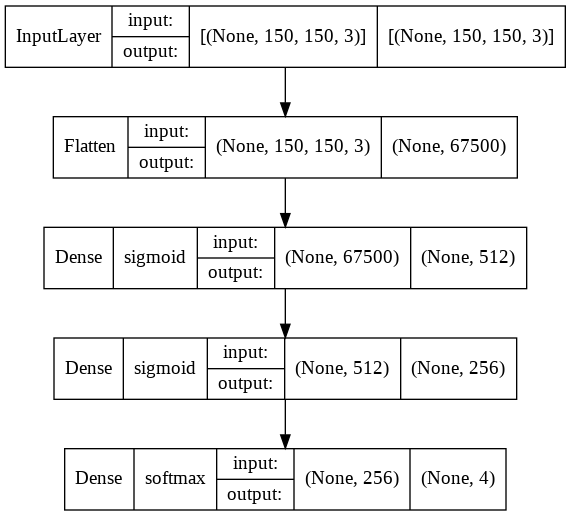

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

# Parámetros de entrenamiento.
learning_rate = 1e-2
batch_size=64
epochs=5

# Arquitectura de la red DNN.
input = keras.layers.Input(shape=(150, 150, 3))
x = keras.layers.Flatten()(input)
x = keras.layers.Dense(512, activation = "sigmoid")(x)
x = keras.layers.Dense(256, activation = "sigmoid")(x)
output = keras.layers.Dense(4, activation='softmax')(x)

dnn = keras.Model(inputs=input, outputs=output)


optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

dnn.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

# Resumen.
dnn.summary()
tf.keras.utils.plot_model(dnn, show_shapes=True, show_layer_names=False, show_layer_activations=True)


In [ ]:
# Entrenamiento
# start = time.time()

# dnn_fit = dnn.fit(x=train_data,
#                   y=train_targets,
#                   batch_size=batch_size,
#                   epochs=epochs,
#                   validation_data=(val_data, val_targets))

# end = time.time()

In [ ]:
#results = pd.DataFrame(dnn_fit.history)
#plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Aplicando Convoluciones y Max Pooling

In [ ]:
def apply_convolution(img_array, filter, weight=1):
  # Copy image to a numpy array
  image_transformed = np.copy(img_array)

  # Get the dimensions of the image
  size_x = image_transformed.shape[0]
  size_y = image_transformed.shape[1]

  # Iterate over the image
  for x in range(1,size_x-1):
    for y in range(1,size_y-1):
        convolution = 0.0
        convolution = convolution + (img_array[x-1, y-1] * filter[0][0])
        convolution = convolution + (img_array[x-1, y] * filter[0][1])  
        convolution = convolution + (img_array[x-1, y+1] * filter[0][2])     
        convolution = convolution + (img_array[x, y-1] * filter[1][0])    
        convolution = convolution + (img_array[x, y] * filter[1][1])    
        convolution = convolution + (img_array[x, y+1] * filter[1][2])    
        convolution = convolution + (img_array[x+1, y-1] * filter[2][0])    
        convolution = convolution + (img_array[x+1, y] * filter[2][1])    
        convolution = convolution + (img_array[x+1, y+1] * filter[2][2])    
        
        # Multiply by weight
        convolution = convolution * weight   
        
        # Check the boundaries of the pixel values
        if(convolution<0):
          convolution=0
        if(convolution>1):
          convolution=1

        # Load into the transformed image
        image_transformed[x, y] = convolution

  return image_transformed


def apply_max_pooling(img_array, pad=True):

  # Copy image to a numpy array
  image_transformed = np.copy(img_array)

  # Get the dimensions of the image
  size_x = image_transformed.shape[0]
  size_y = image_transformed.shape[1]

  # Assign dimensions half the size of the original image
  new_x = int(size_x/2)
  new_y = int(size_y/2)

  # Create blank image with reduced dimensions
  new_image = np.zeros((new_x, new_y))

  # Iterate over the image
  for x in range(0, size_x, 2):
    for y in range(0, size_y, 2):
      
      # Store all the pixel values in the (2,2) pool
      pixels = []
      pixels.append(image_transformed[x, y])
      pixels.append(image_transformed[x+1, y])
      pixels.append(image_transformed[x, y+1])
      pixels.append(image_transformed[x+1, y+1])

      # Get only the largest value and assign to the reduced image
      new_image[int(x/2),int(y/2)] = max(pixels)
  
  if pad:
    padding = np.zeros((size_x, size_y))
    x_min = int(size_x/4)
    x_max = int((size_x/4) * 3)
    y_min = int(size_y/4)
    y_max = int((size_y/4) * 3)
    padding[x_min:x_max, y_min:y_max] = new_image

    return padding

  else:
    return new_image


def transform_img(img_array, filter, weight=1, pad=True):
  
  image = np.copy(img_array)

  if len(image.shape) == 3:
    image = image.reshape(image.shape[:-1])

  conv = apply_convolution(image, filter, weight)
  max_pool = apply_max_pooling(conv, pad=pad)

  return (image, conv, max_pool)

def plot_transformed_img(img_array, filter, weight=1, pad=True):

  image, conv, max_pool = transform_img(img_array, filter, weight, pad=pad)
  plots = [image, conv, max_pool]
  names = ["image", "conv", "max_pool"]

  data_shape = list(image.shape)
  data_shape.insert(0, 3)

  data = np.zeros(data_shape)

  for i, plot in enumerate([image, conv, max_pool]):
    data[i] = plot
  
  plot = px.imshow(data, facet_col=0)

  for i, name in enumerate(names):
    plot.layout.annotations[i]['text'] = f'{name}'

  return plot


Podemos ver el efecto de aplicar una convolución y max pooling con distintos filtros sobre algunas imágenes del set de train.

La **convolución** es una operación matricial donde intervienen una matriz más pequeña (filtro o kernel) y una matriz más grande (imagen). La matriz pequeña se desplaza por la matriz más grande, realizando la sumatoria de la multiplicación elemento a elemento.

El objetivo principal es que cada filtro aplicado representa una variable y el resultado de aplicar la convolución se obtiene un *mapa de respuesta* a esa variable en la imagen.

Parámetros Generales:

* Tamaño del filtro: 3x3 o 5x5
* Stride: 1


![Convolución](https://miro.medium.com/max/1400/1*D6iRfzDkz-sEzyjYoVZ73w.gif)

El **max pooling** es una operación donde se elige un tamaño de matrix menor y se la desplaza sobre una matriz mayor, obteniendo el mayor de los elementos en cada desplazamiento.

El objetivo principal es reducir la dimensionalidad del mapa de respuesta a las variables, manteniendo su estructura y los valores relevantes.

Parámetros Generales:

* Tamaño: 2x2
* Stride: 2

![Max Pooling](https://nico-curti.github.io/NumPyNet/NumPyNet/images/maxpool.gif)

In [ ]:
# Filtros para probar al aplicar convolución:
filter_borde = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
filter_h = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]
filter_v = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]

filters = [filter_borde, filter_h, filter_v]

# El parámetro weight permite escalar los valores del filtro aplicado.
# Sirve para mantener la suma de los valores del filtro entre 0 y 1.
weight = 1

In [ ]:
# Probamos los filtros anteriores.
for i, filter in enumerate(filters, start=0):
  #i = 3
  imagen = import_img_as_array(directory, train["image_name"][i], "grayscale") / 255
  plot_transformed_img(imagen, filter, weight = 1, pad=True).show()

### CNN

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-4
batch_size=32
epochs=50

# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(16, activation = "relu")(x)
x = keras.layers.Dense(16, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_1 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_1.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_1_fit = conv_1.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
125/125 [==============================] - 16s 33ms/step - loss: 1.2034 - accuracy: 0.4285 - val_loss: 0.9672 - val_accuracy: 0.5960
Epoch 2/50
125/125 [==============================] - 4s 30ms/step - loss: 0.8133 - accuracy: 0.6605 - val_loss: 0.7506 - val_accuracy: 0.7060
Epoch 3/50
125/125 [==============================] - 4s 30ms/step - loss: 0.6728 - accuracy: 0.7320 - val_loss: 0.6704 - val_accuracy: 0.7200
Epoch 4/50
125/125 [==============================] - 4s 32ms/step - loss: 0.6062 - accuracy: 0.7495 - val_loss: 0.5990 - val_accuracy: 0.7460
Epoch 5/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5649 - accuracy: 0.7738 - val_loss: 0.5992 - val_accuracy: 0.7500
Epoch 6/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5366 - accuracy: 0.7790 - val_loss: 0.6271 - val_accuracy: 0.7320
Epoch 7/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5172 - accuracy: 0.7933 - val_loss: 0.5398 - val_accuracy: 0.776

In [ ]:
conv_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 126)       72702 

In [ ]:
print(f'Training Time: {end - start} seconds.')

Training Time: 203.30505204200745 seconds.


In [ ]:
model_evaluation(conv_1, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val      test
loss      0.102474  0.278044  0.271835
accuracy  0.968000  0.896000  0.913000

In [ ]:
results = pd.DataFrame(conv_1_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Overfitting

Si agregamos más capas densas finales con mayor cantidad de unidades o neuronas, aumentamos la cantidad de parámetros del la red y le damos una mayor flexibilidad. Además, aumentamos el learning-rate para acelerar el entrenamiento. 

Esto lleva a la red a ajustar demasiado a los datos de entrenamiento y logra una menor generalización en datos nuevos. El modelo está memorizando los datos de entrenamiento.

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_2 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_2.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_2_fit = conv_2.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
125/125 [==============================] - 4s 31ms/step - loss: 0.8564 - accuracy: 0.5968 - val_loss: 0.6626 - val_accuracy: 0.7140
Epoch 2/50
125/125 [==============================] - 4s 28ms/step - loss: 0.6175 - accuracy: 0.7430 - val_loss: 0.8333 - val_accuracy: 0.6800
Epoch 3/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5291 - accuracy: 0.7807 - val_loss: 0.5251 - val_accuracy: 0.7780
Epoch 4/50
125/125 [==============================] - 3s 28ms/step - loss: 0.4739 - accuracy: 0.8023 - val_loss: 0.4613 - val_accuracy: 0.8040
Epoch 5/50
125/125 [==============================] - 4s 28ms/step - loss: 0.4216 - accuracy: 0.8325 - val_loss: 0.5201 - val_accuracy: 0.7760
Epoch 6/50
125/125 [==============================] - 4s 28ms/step - loss: 0.3684 - accuracy: 0.8545 - val_loss: 0.5842 - val_accuracy: 0.7760
Epoch 7/50
125/125 [==============================] - 4s 28ms/step - loss: 0.3195 - accuracy: 0.8770 - val_loss: 0.3506 - val_accuracy: 0.8660

In [ ]:
conv_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 126)       72702 

In [ ]:
model_evaluation(conv_2, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val      test
loss      0.00003  0.891304  0.910532
accuracy  1.00000  0.910000  0.906000

In [ ]:
results = pd.DataFrame(conv_2_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Regularization - Dropout

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_3 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_3.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_3_fit = conv_3.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
125/125 [==============================] - 5s 31ms/step - loss: 1.0298 - accuracy: 0.5017 - val_loss: 0.7254 - val_accuracy: 0.6740
Epoch 2/50
125/125 [==============================] - 4s 29ms/step - loss: 0.7930 - accuracy: 0.6467 - val_loss: 0.8573 - val_accuracy: 0.6120
Epoch 3/50
125/125 [==============================] - 4s 28ms/step - loss: 0.6658 - accuracy: 0.7103 - val_loss: 0.5577 - val_accuracy: 0.7420
Epoch 4/50
125/125 [==============================] - 4s 28ms/step - loss: 0.6012 - accuracy: 0.7483 - val_loss: 0.5430 - val_accuracy: 0.7700
Epoch 5/50
125/125 [==============================] - 4s 29ms/step - loss: 0.5493 - accuracy: 0.7692 - val_loss: 0.5179 - val_accuracy: 0.7800
Epoch 6/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5155 - accuracy: 0.7952 - val_loss: 0.5346 - val_accuracy: 0.7720
Epoch 7/50
125/125 [==============================] - 4s 28ms/step - loss: 0.4852 - accuracy: 0.8117 - val_loss: 0.3997 - val_accuracy: 0.8440

In [ ]:
conv_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 126)       72702 

In [ ]:
model_evaluation(conv_3, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val      test
loss      0.013386  0.600243  0.541925
accuracy  0.995500  0.902000  0.908000

In [ ]:
results = pd.DataFrame(conv_3_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Data Augmentation

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate=1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=42)(input)
x = keras.layers.RandomRotation(0.1, seed=42)(x)
x = keras.layers.RandomZoom(0.2, seed=42)(x)

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_4 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_4.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])


# Entrenamos el modelo.

start = time.time()

conv_4_fit = conv_4.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
125/125 [==============================] - 15s 34ms/step - loss: 0.8953 - accuracy: 0.5813 - val_loss: 1.6451 - val_accuracy: 0.4660
Epoch 2/50
125/125 [==============================] - 4s 30ms/step - loss: 0.6997 - accuracy: 0.6998 - val_loss: 0.7109 - val_accuracy: 0.6760
Epoch 3/50
125/125 [==============================] - 4s 30ms/step - loss: 0.6331 - accuracy: 0.7268 - val_loss: 0.6873 - val_accuracy: 0.7180
Epoch 4/50
125/125 [==============================] - 4s 30ms/step - loss: 0.5895 - accuracy: 0.7510 - val_loss: 0.5432 - val_accuracy: 0.7880
Epoch 5/50
125/125 [==============================] - 4s 31ms/step - loss: 0.5368 - accuracy: 0.7730 - val_loss: 0.5412 - val_accuracy: 0.8040
Epoch 6/50
125/125 [==============================] - 4s 31ms/step - loss: 0.5147 - accuracy: 0.7975 - val_loss: 0.4683 - val_accuracy: 0.8120
Epoch 7/50
125/125 [==============================] - 4s 30ms/step - loss: 0.4713 - accuracy: 0.8135 - val_loss: 0.5340 - val_accuracy: 0.802

In [ ]:
conv_4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                           

In [ ]:
model_evaluation(conv_4, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val     test
loss      0.080823  0.239149  0.36951
accuracy  0.968000  0.922000  0.91500

In [ ]:
results = pd.DataFrame(conv_4_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Early Stopping

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=32
epochs=50


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(input)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dense(32, activation = "relu")(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_5 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_5.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)]


# Entrenamos el modelo.

start = time.time()

conv_5_fit = conv_5.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callback,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/50
125/125 [==============================] - 14s 32ms/step - loss: 0.8752 - accuracy: 0.5900 - val_loss: 0.6831 - val_accuracy: 0.6920
Epoch 2/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5882 - accuracy: 0.7580 - val_loss: 0.7386 - val_accuracy: 0.7100
Epoch 3/50
125/125 [==============================] - 4s 28ms/step - loss: 0.5236 - accuracy: 0.7772 - val_loss: 0.4980 - val_accuracy: 0.7880
Epoch 4/50
125/125 [==============================] - 4s 28ms/step - loss: 0.4525 - accuracy: 0.8180 - val_loss: 0.4437 - val_accuracy: 0.8200
Epoch 5/50
125/125 [==============================] - 4s 29ms/step - loss: 0.4066 - accuracy: 0.8347 - val_loss: 0.4156 - val_accuracy: 0.8320
Epoch 6/50
125/125 [==============================] - 4s 29ms/step - loss: 0.3108 - accuracy: 0.8823 - val_loss: 0.3805 - val_accuracy: 0.8560
Epoch 7/50
125/125 [==============================] - 4s 28ms/step - loss: 0.2793 - accuracy: 0.8910 - val_loss: 0.3739 - val_accuracy: 0.852

In [ ]:
conv_5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 126)       72702 

In [ ]:
model_evaluation(conv_5, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val      test
loss      0.188214  0.334583  0.328393
accuracy  0.930500  0.878000  0.880000

In [ ]:
results = pd.DataFrame(conv_5_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

### Dropout + Data Augmentation + Early Stopping

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=64
epochs=200


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=42)(input)
x = keras.layers.RandomRotation(0.1, seed=42)(x)
x = keras.layers.RandomZoom(0.2, seed=42)(x)

x = keras.layers.Conv2D(32, (3,3), activation = "relu")(x) 
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(64, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(126, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Conv2D(256, (3,3), activation = "relu")(x)
x = keras.layers.MaxPool2D((2,2))(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_6 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_6.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)]


# Entrenamos el modelo.

start = time.time()

conv_6_fit = conv_6.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callback,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/200
63/63 [==============================] - 18s 75ms/step - loss: 1.1940 - accuracy: 0.4283 - val_loss: 0.8066 - val_accuracy: 0.6600
Epoch 2/200
63/63 [==============================] - 4s 58ms/step - loss: 0.8462 - accuracy: 0.6313 - val_loss: 0.7501 - val_accuracy: 0.7180
Epoch 3/200
63/63 [==============================] - 4s 57ms/step - loss: 0.7804 - accuracy: 0.6532 - val_loss: 0.7835 - val_accuracy: 0.6780
Epoch 4/200
63/63 [==============================] - 4s 57ms/step - loss: 0.7357 - accuracy: 0.6800 - val_loss: 0.6004 - val_accuracy: 0.7500
Epoch 5/200
63/63 [==============================] - 4s 58ms/step - loss: 0.7088 - accuracy: 0.7048 - val_loss: 0.6732 - val_accuracy: 0.6980
Epoch 6/200
63/63 [==============================] - 4s 57ms/step - loss: 0.6312 - accuracy: 0.7473 - val_loss: 0.5435 - val_accuracy: 0.7680
Epoch 7/200
63/63 [==============================] - 4s 57ms/step - loss: 0.6136 - accuracy: 0.7460 - val_loss: 0.6786 - val_accuracy: 0.7340
Epoch

In [ ]:
conv_6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                           

In [ ]:
model_evaluation(conv_6, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train      val      test
loss      0.100306  0.21829  0.319922
accuracy  0.963750  0.93000  0.915000

In [ ]:
results = pd.DataFrame(conv_6_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

In [ ]:
# conv_6.save("conv_6.h5", 
#             overwrite=True,
#             include_optimizer=True,
#             save_format=None)

### Transfer Learning

In [ ]:
# Limpiamos la sesión de tensorflow.
tf.keras.backend.clear_session()
# Definimos una semilla para el entrenamiento.
tf.keras.utils.set_random_seed(42)

vgg16 = keras.applications.vgg16.VGG16(weights="imagenet",
                                       include_top=False,
                                       input_shape=(150, 150, 3))

vgg16.trainable = False


# Parámetros de Entrenamiento.

learning_rate = 1e-3
batch_size=64
epochs=200


# Arquitectura del modelo.

input = keras.layers.Input(shape=(150, 150, 3))

x = keras.layers.RandomFlip("horizontal", seed=42)(input)
x = keras.layers.RandomRotation(0.1, seed=42)(x)
x = keras.layers.RandomZoom(0.2, seed=42)(x)

#x = keras.applications.vgg16.preprocess_input(x)
x = vgg16(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(64, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

x = keras.layers.Dense(32, activation = "relu")(x)
x = keras.layers.Dropout(0.3, seed=42)(x)

output = keras.layers.Dense(4, activation='softmax')(x)

conv_7 = keras.Model(inputs=input, outputs=output)


# Compilamos el modelo.

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

conv_7.compile(loss="sparse_categorical_crossentropy", 
               optimizer=optimizer,
               metrics=["accuracy"])

callback = [keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15, restore_best_weights=True)]

# Entrenamos el modelo.

start = time.time()

conv_7_fit = conv_7.fit(x=train_data,
                  y=train_targets,
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callback,
                  validation_data=(val_data, val_targets))

end = time.time()

Epoch 1/200
63/63 [==============================] - 14s 203ms/step - loss: 0.7812 - accuracy: 0.6615 - val_loss: 0.3340 - val_accuracy: 0.8960
Epoch 2/200
63/63 [==============================] - 13s 204ms/step - loss: 0.4585 - accuracy: 0.8300 - val_loss: 0.2255 - val_accuracy: 0.9320
Epoch 3/200
63/63 [==============================] - 12s 196ms/step - loss: 0.3445 - accuracy: 0.8775 - val_loss: 0.1921 - val_accuracy: 0.9340
Epoch 4/200
63/63 [==============================] - 12s 188ms/step - loss: 0.3230 - accuracy: 0.8920 - val_loss: 0.2046 - val_accuracy: 0.9220
Epoch 5/200
63/63 [==============================] - 12s 186ms/step - loss: 0.2971 - accuracy: 0.9005 - val_loss: 0.1737 - val_accuracy: 0.9420
Epoch 6/200
63/63 [==============================] - 12s 183ms/step - loss: 0.2741 - accuracy: 0.9032 - val_loss: 0.1722 - val_accuracy: 0.9400
Epoch 7/200
63/63 [==============================] - 12s 187ms/step - loss: 0.2523 - accuracy: 0.9128 - val_loss: 0.1681 - val_accuracy:

In [ ]:
conv_7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 150, 150, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 150, 150, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 150, 150, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                             

In [ ]:
print(f'Training Time: {end - start} seconds.')

Training Time: 409.14421582221985 seconds.


In [ ]:
model_evaluation(conv_7, train_data, train_targets, val_data, val_targets, test_data, test_targets)

train       val      test
loss      0.090656  0.155526  0.186725
accuracy  0.968000  0.954000  0.935000

In [ ]:
results = pd.DataFrame(conv_7_fit.history)
plot_train_metrics(results, ['loss', 'accuracy'], ['val_loss', 'val_accuracy'], title=None)

## Guardar un Modelo Entrenado

In [ ]:
# conv_7.save("conv_7.h5", 
#              overwrite=True,
#              include_optimizer=True,
#              save_format=None)

## Cargar un Modelo Entrenado

In [ ]:
uploaded = files.upload()

In [ ]:
model = keras.models.load_model("conv_6.h5")

## Predicciones

In [ ]:
def predict_from_url(url, model):

  url = tf.keras.utils.get_file('Court', origin=url)
  imagen = tf.keras.preprocessing.image.load_img(url, target_size=(150, 150))
  os.remove(url)
  array = tf.keras.preprocessing.image.img_to_array(imagen)
  plot_img(array, targets=[np.argmax(model.predict(array.reshape(1, 150, 150, 3)))]).show()


* https://i0.wp.com/revistadiners.com.co/wp-content/uploads/2016/02/revenant2_800x669.jpg?fit=800%2C669&ssl=1

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTUZGrnzmUNlAvwO144Yf9X4KhAVKISeMr91w&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS4F9F4VMv-bgCFJVkUe6wKmjuqpwXKWDhoQA&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ2lgpfQehowONh05dvThowWtPVqBAqPbUE6g&usqp=CAU

* https://e3.365dm.com/22/04/1600x900/skynews-spain-beach_5731908.jpg?20220407144945

* https://shrm-res.cloudinary.com/image/upload/c_crop,h_745,w_1325,x_0,y_34/w_auto:100,w_1200,q_35,f_auto/v1/Global%20HR/Madrid1m_ko7ivu.jpg

* https://i.pinimg.com/originals/82/3d/ed/823dedd219c895bbb6113945856fb7ee.jpg

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ7mfbs60BMfzep8Ov1wP_rPeE-h8NcJp44yQ&usqp=CAU

* https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTBJZ8kUYtDqZoGf8DCW3N18xm2ewSmaldyQw&usqp=CAU

* https://www.northlandscapes.com/files/images/portfolio/northlandscapes-1801-faroe-islands-mountains-and-sea-03.jpg

* https://www.buenosaires.gob.ar/sites/gcaba/files/field/image/mar_del_plata.jpeg

24576/11486 [================================================================] - 0s 0us/step



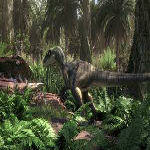

In [ ]:
image_url = ""

predict_from_url(image_url, conv_7)

Predicción: Street
[[0. 0. 0. 1.]]
